# Lecture 18: Dimensionality Reduction

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/19J80Hg1ZLxLrpHWbgxFZoyPfql_AdeGN)


* Many problems have thousands or millions of features, and similar number of samples

* Want to reduce the number of dimensions i.e. features 

* Dimesionality reduction is lossy 

* It may (or may not) speed up training but (almost certainly) can degrade result quality 
* Also makes pipelines more complex
* Should always try using original data before considering dimensionality reduction


* Very useful for visualization (2D, 3D representations more intuitive) 
* Two main approaches: projection, manifold learning.
* Three most popular techniques: PCA, Kernel PCA, LLE.

## Curse of Dimensionality
Many things behave differently in high-D space.

For example
- Pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension)
- But in a 10,000-dimensional unit hypercube (a 1 × 1 × ⋯ × 1 cube, with ten thousand 1s), this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.

## Projection 

- In most real-world problems, training instances are not spread out uniformly across all dimensions. 
- Many features are almost constant, while others are highly correlated. 
- As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace

<img src="Lecture18_Images/Projection.png" alt="Drawing" style="width: 300px;"/>



However projection doesn't work for twisted data sets. In this case a _manifold_ is defined.

<img src="Lecture18_Images/Swiss.png" alt="Drawing" style="width: 600px;"/>



## Manifold 

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called Manifold Learning. 

It relies on the manifold assumption, also called the manifold hypothesis: that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.


Projection versus unrolling

<!-- <img src="Lecture18_Images/unroll.png" alt="Drawing" style="width: 500px;"/> -->
![](Lecture18_Images/unroll.png)

In [1]:
import numpy as np
import numpy.random as rnd

# build a 3D dataset
rnd.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1 

#3D data from example 
angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * rnd.randn(m)

# mean-normalize the data
X = X - X.mean(axis=0)

# apply PCA to reduce to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# recover 3D points projected on 2D plane
X2D_inv = pca.inverse_transform(X2D)

In [2]:
# utility to draw 3D arrows
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# express plane as function of x,y
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

(-1.0, 1.0)

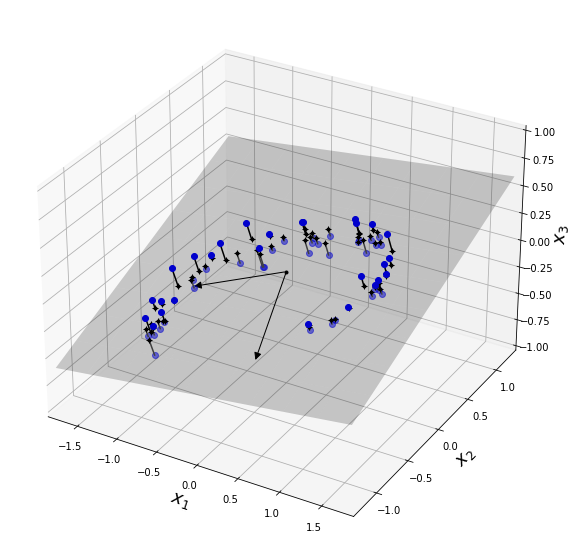

In [3]:
# plot 3D dataset, plane & projections

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X2D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X2D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X2D_inv[i, 2]:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k+")
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

In [4]:
#save_fig("dataset_3d_plot")
plt.show()

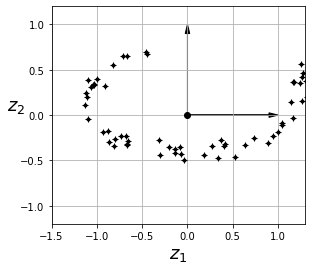

In [5]:
# 2D projection equivalent:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

(-12.0, 15.0)

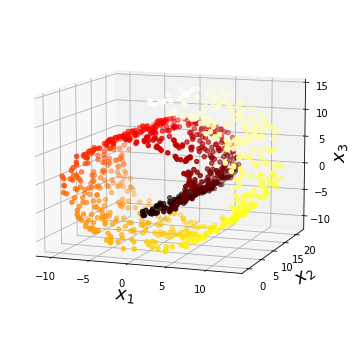

In [6]:
# Swiss roll visualization:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

In [7]:
#save_fig("swiss_roll_plot")
plt.show()

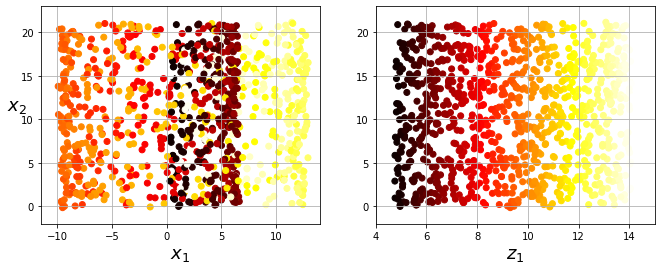

In [8]:
# "squashed" swiss roll visualization:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

In [9]:
#save_fig("squished_swiss_roll_plot")
plt.show()

## Principle Component Analysis (PCA) 

* Most popular DR algorithm
- 1) Finds hyperplane that lies closest to the data
- 2) Projects data onto it


## Principal Components

PCA finds linear combinations of variables responsible for largest amount of _variance_ in dataset.

Each axis vector is called a principal component. (PC)

PCs found using Singular Value Decomposition (SVD), a matrix factorization technique, of the covariance matrix of the data. Also called eigenfunction or eigenmatrix decomposition. Also called diagonalisation.

$$X=U \Sigma U^T$$
 
$U$ are is a matrix of the eigenfunctions, $\Sigma$ are the eigenvalues. SVD decomposes training set matrix X into dot product of three matrices.

**Note: PCA assumes data is centered around origin. Scikit PCA will adjust data for you if needed.**

In [10]:
# use NumPy svd() to get principal components of training set,
# then extract 1st two PCs.
angle = np.pi / 5
stretch = 5
m = 200

#make a 2D ellipsoid 
rnd.seed(3)
X = rnd.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate
X_centered = X - X.mean(axis=0)

#do the PCA using SVD 
U,s,UT = np.linalg.svd(X_centered)

#print principle components
c1, c2 = UT.T[:,0], UT.T[:,1]
print(c1,c2)

[-0.79644131 -0.60471583] [-0.60471583  0.79644131]


$$X_{d,{\rm proj}}=X U^T$$

In [11]:
# project training set onto plane defined by 1st two PCs.
W2 = UT.T[:, :2]
X2D = X_centered.dot(W2)

### Scikit PCA

Uses SVD decomposition as before.

You can access each PC using ```components_``` variable

In [12]:
from sklearn.decomposition import PCA #use PCA implicit instead of SVD
pca = PCA(n_components = 2) #set up 
X2D = pca.fit_transform(X) #execute 

print(pca.components_[0])
print(pca.components_.T[:,0])

[-0.79644131 -0.60471583]
[-0.79644131 -0.60471583]


### Explained Variance Ratio

Very useful metric: proportion of dataset's variance along the axis of each PC component.

In [13]:
# 95% of dataset variance explained by 1st axis in this example
print(pca.explained_variance_ratio_)

[0.95369864 0.04630136]


### Choosing Right Dimensions

No need to choose arbitrary number of dimensions

Instead pick d that cumulatively accounts for a sufficient amount, ex: 95%.

In [14]:
# find minimum d to preserve 95% of training set variance
pca = PCA() #set up 
pca.fit(X) #execute 
cumsum = np.cumsum(pca.explained_variance_ratio_) #cumulative sum of the explained variance
d = np.argmax(cumsum >= 0.95) + 1
print(d) 

1


### PCA for Compression

Example applying PCA to MNIST dataset with 95% preservation = results in ~150 features (original = 28x28 = 784)


In [15]:
#download MNIST data set (numerical digits)
from six.moves import urllib
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [16]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
from sklearn.decomposition import PCA
import numpy as np 

#number of components in the data, compared to 28*28=784 in the original
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [18]:
#create reduced/compressed training data 
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train) #reduced data set PCA space 
X_recovered = pca.inverse_transform(X_reduced) #compressed in original space
pca.n_components_

154

In [19]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

In [20]:
import matplotlib
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

AttributeError: 'str' object has no attribute 'reshape'

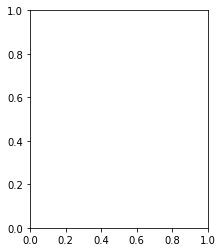

In [21]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [ ]:
#save_fig("mnist_compression_plot")
plt.show()

### Incremental PCA 

One problem with using PCA on a training set is that it requires the entire training set to be read into memory at once. Not great for large training data. 

Instead *Incremental PCA (IPCA)* splits the data into batches, and allows for combination. 



In [ ]:
# split MNIST into 100 minibatches using Numpy array_split()
# reduce MNIST down to 154 dimensions as before.
# note use of partial_fit() for each batch.

from sklearn.decomposition import IncrementalPCA
#from __future__ import print_function #because I'm using p2.7 

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches): #split data X from previous example
    print(".", end=" ")
    inc_pca.partial_fit(X_batch) #partial fit to each batch

X_mnist_reduced_inc = inc_pca.transform(X_train) #combines into one

In [ ]:
np.sum(inc_pca.explained_variance_ratio_)

In [ ]:
X_recovered_inc = inc_pca.inverse_transform(X_mnist_reduced_inc)

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc[::2100])
plt.title("ICA Compressed", fontsize=16)

In [ ]:
#save_fig("mnist_compression_plot")
plt.show()

### Randomized PCA 

This is a stochastic algorithm that quickly finds an approximation of the first d principal components. Its computational complexity is ${\mathcal O}( m\times d^2) + {\mathcal O}( d^3)$, instead of ${\mathcal O}( m \times n^2) + {\mathcal O}( n^3)$, so it is dramatically faster than the previous algorithms when d is much smaller than n.

These methods use random sampling of matrix elements to identify a subspace that captures most of the action of a matrix. The input matrix is then compressed (either explicitly or implicitly) to this subspace, and the reduced matrix is manipulated deterministically to obtain the desired low-rank factorization. 

SciKit Learn uses the Halko algorithm https://arxiv.org/abs/0909.4061

In [ ]:
#(for some reason this crashes jupyter!, but syntax is below)
rpca = PCA(svd_solver='randomized')
X_reduced = rpca.fit_transform(X_train)
X_recovered = rpca.inverse_transform(X_reduced)
rpca.n_components_

### Kernel PCA

Kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines (SVM). 

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. 

This is called Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.


In [ ]:
# Below: Swiss roll reduced to 2D using 3 techniques:
# 1) linear kernel (equiv to PCA)
# 2) RBF kernel (radial basis function)
# 3) sigmoid kernel (logistic)

from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X) 

In [ ]:
#different kernels can be used
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

y = t > 6.9 #define y 
 
#loop over methods and plot the projection of the Swiss roll
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot), plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

In [ ]:
plt.show()
#different higher_D projections result in different reduced PCA sub-spaces 

## What hyperparameters to use?

```rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)```

Need a performance measure e.g. classification, or MSE of fit, then can search methods and parameters.

In [ ]:
#in this case use logistic regression for classification and search over kernels and gamma parameter
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np 

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params_)

### LLE (Locally Linear Embedding)

Powerful nonlinear dimensionality reduction tool

Manifold Learning: *doesn't rely on projections*

LLE measures how each instance relates to closest neighbors, then looks for low-D representation where local relations are best preserved.

Here’s how LLE works: 

## First Step: 

- First, for each training instance $x(i)$, the algorithm identifies its $k$ closest neighbors, 
- Then tries to reconstruct $x(i)$ as a linear function of these neighbors

More specifically, it finds the weights $w_{ij}$ such that the squared distance between $x(i)$ and $\sum_{i=1}^m w_{ij}x(j)$ is as small as possible. 

- Weights are normalised $\sum w_{ij}=1$ for each training instance $x(i)$ 

## Second Step 

The second step is to map the training instances into a d-dimensional space (where $d < n$) while preserving these local relationships as much as possible.

If z(i) is the d-space equivalent of x(i) then we want $z(i)-\sum_{i=1}^m w_{ij}z(j)$ to be a minimum for **a fixed set of weights** from step 1. 

Note step 2 optimises positions of $z$ for fixed $w$, step 1 optimises the $w$ for fixed positions $x$



In [ ]:
# Use LLE to unroll a Swiss Roll.

from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=41)

lle = LocallyLinearEmbedding(
    n_neighbors=10, #k nearest neighbours 
    n_components=2, #dimension of final space 
    random_state=42)

X_reduced = lle.fit_transform(X)

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

In [ ]:
plt.show()

### Other dimensional reduction methods in SciKit Learn 

There are many dimensional reduction algorithms. Some available in SciKit Learn are: 
    
- Multi-D Scaling (MDS): tries to reduce D while keep instance distance the same
- Isomap: connects each instance to its neighbours then preserves the geodesic distance between instances 
- t-Distributed Stochastic Neighbour Embedding (tSNE): preserves similar instances that are close and pushes dis-similar instances apart
- Linear Discriminant Analysis (LDA): a classification algorithm that learns the most discriminative axes combination (a type of stacking)

### You can now do Exercise 1 in Lecture18_DimentionalityReduction_Exercises.ipynb